# Declare all the imports

In [1]:
import glob
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction import image
from PIL import Image
import re
import time
import tensorflow as tf
import collections
import skimage.io
import skimage.segmentation
from skimage import transform as tr
from matplotlib.pyplot import imshow
import os
from operator import add
from sklearn.metrics import classification_report
from scipy.misc import imread
import datetime
import itertools

/home/bharadwaj/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
print(sys.path)
!echo $PATH

/home/bharadwaj/anaconda2/bin/python
2.7.14 |Anaconda, Inc.| (default, Dec  7 2017, 17:05:42) 
[GCC 7.2.0]
sys.version_info(major=2, minor=7, micro=14, releaselevel='final', serial=0)
['', '/home/bharadwaj/anaconda2/lib/python27.zip', '/home/bharadwaj/anaconda2/lib/python2.7', '/home/bharadwaj/anaconda2/lib/python2.7/plat-linux2', '/home/bharadwaj/anaconda2/lib/python2.7/lib-tk', '/home/bharadwaj/anaconda2/lib/python2.7/lib-old', '/home/bharadwaj/anaconda2/lib/python2.7/lib-dynload', '/home/bharadwaj/anaconda2/lib/python2.7/site-packages', '/home/bharadwaj/anaconda2/lib/python2.7/site-packages/OpenEXR-1.3.2-py2.7-linux-x86_64.egg', '/home/bharadwaj/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/bharadwaj/.ipython']
/home/bharadwaj/anaconda2/bin:/home/bharadwaj/anaconda2/bin:/home/bharadwaj/bin:/home/bharadwaj/.local/bin:/home/bharadwaj/anaconda2/bin:/home/bharadwaj/anaconda2/bin:/home/bharadwaj/bin:/home/bharadwaj/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/

# Function to sort a list based on patch number

In [3]:
def stringSplitByNumbers(x):
    r = re.compile('(\d+)')
    l = r.split(x)
    return [int(y) if y.isdigit() else y for y in l]

# Steps for pre-processing the data

1. Remove first and last 5 files from the four splits of Berlin data
2. Remove images that do not have corresponding depth images (also 'highlight' data)
3. Remove files whose corresponding depth images have "0" value
4. Check for consistency if necessary (Remove low contrast or burned images)
5. Resize the images
6. Normalize the data
7. Create patches from single image
8. Resize the labels again to match the network size
9. Augment if necessary 
10. Create HDF5 and train/val/test list

# Check for empty Depth images

In [ ]:
import os
exrList = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/q2_orig/*.exr")
for exrs in exrList:    
    exrImage = cv2.imread(exrs, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)
    #exrName = exrs.split('/')[6]
    imageName = exrs.split('/')[7].split('.')[0]
    #if exrImage.max() > 1.0 and imagexxx.min() < 0.0:
    if exrImage.max() == 0.0 and exrImage.min() == 0.0:
        print imageName, "\t", exrImage.max(), "\t", exrImage.min()    
        #print imagexxx.shape
        #cmd = "rm /home/bharadwaj/CaffeUNet/dataset4/Berlin_data/leftovers/data_val/%s.*" %(imageName)       
        #os.system(cmd)
        #print exrName, imageName                

# Remove "highlight" data

In [ ]:
import os
cmd1 = "rm /home/bharadwaj/CaffeUNet/dataset4/q1_res1544x1159/*highlight*"
cmd2 = "rm /home/bharadwaj/CaffeUNet/dataset4/q2_res1544x1159/*highlight*"
cmd3 = "rm /home/bharadwaj/CaffeUNet/dataset4/q3_res1544x1159/*highlight*"
cmd4 = "rm /home/bharadwaj/CaffeUNet/dataset4/q4_res1544x1159/*highlight*"
os.system(cmd1)
os.system(cmd2)
os.system(cmd3)
os.system(cmd4)

# Check for consistency in the label data

In [ ]:
pngList = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/q1_orig/*.jpg")
for pngs in pngList:
    pngImage = cv2.imread(pngs)
    pngName = pngs.split('/')[6]
    if np.mean(pngImage, dtype=np.float64) <= 50  or np.mean(pngImage, dtype=np.float64) >= 180:
    #if np.any(pngImage[:,:] == 34):
        print pngName, "\t\t", pngImage.max(), "\t\t", pngImage.min() 

# Remove files without depth images

In [ ]:
files = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/allImages/*")
path = "/home/bharadwaj/CaffeUNet/dataset4/allImages/"
imageList = []

for images in files:     
    imageName = images.split('/')[6].split('.')[0]
    if imageName not in imageList:
        imageList.append(imageName)
        pngFile = path+imageName+'.png'          
        jpgFile = path+imageName+'.jpg'
        exrFile = path+imageName+'.exr'        

        #if pngFile not in files or jpgFile not in files or exrFile not in files:
        if exrFile not in files or pngFile not in files or jpgFile not in files:
            cmd = "rm %s %s %s" %(pngFile,jpgFile,exrFile)
            os.system(cmd)             

# Resizing image using openCV

In [ ]:
dirList = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/resnet34/without_depth/modPredDir_loss_1_216/*")
for dirs in dirList:
    dirName = dirs.split("/")[8]
    origList = glob.glob(dirs+"/*")
    for imgs in origList:    
        #image = cv2.imread(imgs, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        image = cv2.imread(imgs)
        imgName = imgs.split('/')[8]        
        #resizedImg =  cv2.resize(image, (51, 51), interpolation=cv2.INTER_LINEAR)
        #resizedImg = image_resize(image, width=1396, height=1396, inter=cv2.INTER_CUBIC)
        resizedImg = cv2.resize(image, (512, 512), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/%s/%s" %(dirName,imgName),resizedImg)

In [ ]:
imgs = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/ResNet_Enc_DDNET_Dec/qualitative_results/modPredDir/*")
for images in imgs:
    image = cv2.imread(images)
    #image = cv2.imread(images,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    #image = image*150
    imgName = images.split('/')[9]
    resizedImg = cv2.resize(image, (300, 300), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/Experiments/ResNet_Enc_DDNET_Dec/qualitative_results/modPredDir_300X300/%s" %(imgName),resizedImg)

In [ ]:
imgs = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/train/*")
for images in imgs:
    imgName = images.split('/')[7].split(".")[0]
    image = cv2.imread(images,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if image.shape[0] != 512 or image.shape[1] != 512:
        cmd = "mv /home/bharadwaj/CaffeUNet/dataset4/Berlin_data/train/%s.* /home/bharadwaj/CaffeUNet/dataset4/Berlin_data/leftovers/data_train" %(imgName)
        os.system(cmd)         

In [ ]:
img = cv2.imread("/home/bharadwaj/Desktop/scn.jpg")
img = cv2.resize(img, (960, 720), interpolation=cv2.INTER_NEAREST)
cv2.imwrite("/home/bharadwaj/Desktop/scn2.jpg",img)

# Pad images with 0s

In [ ]:
imgList = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/tmp/*")
for images in imgList:
    imgname,extension = images.split('/')[6].split('.')     
    img = cv2.imread(images,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH )
    if extension != 'jpg':        
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) 
    img = np.stack([np.pad(img[:,:,c], (175,175), mode='constant', constant_values=(0,0)) for c in range(3)], axis=2)
    #print img.shape
    cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/tmp/x%s.%s" %(imgname,extension), img)


In [ ]:
hdr = cv2.imread("/home/bharadwaj/CaffeUNet/dataset4/_cam1_1509443564718_000022.exr",cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH )
hdr = hdr*10000.0
#hdr_min = int(hdr.min())
#hdr_max = int(hdr.max())
un = np.unique(hdr)
print un
un = map(int, un)
print un
#print hdr_min,hdr_max
#print hdr.shape
#print np.unique(hdr)
'''
for i in range(0,hdr.shape[0]):
    for j in range(0,hdr.shape[1]):
        if i<64 and hdr[i][j]!=0:
            hdr[i][j]=50
        if i<128 and i>=64 and hdr[i][j]!=0:
            hdr[i][j]=100       
        if i<192 and i>=128 and hdr[i][j]!=0:
            hdr[i][j]=150       
        if i<256 and i>=192 and hdr[i][j]!=0:
            hdr[i][j]=200
        if i<512 and i>=256 and hdr[i][j]!=0:
            hdr[i][j]=255
        
'''
'''
for i in range(0,hdr.shape[0]):
    for j in range(0,hdr.shape[1]):
        if hdr[i][j] <=1.0 and hdr[i][j] >0.999999:
            hdr[i][j] = 255
        if hdr[i][j] <=0.999999 and hdr[i][j] >0.988888:
            hdr[i][j] = 235
        if hdr[i][j] <=0.988888 and hdr[i][j] >0.977777:
            hdr[i][j] = 215
        if hdr[i][j] <=0.977777 and hdr[i][j] >0.966666:
            hdr[i][j] = 195
        if hdr[i][j] <=0.966666 and hdr[i][j] >0.955555:
            hdr[i][j] = 175
        if hdr[i][j] <=0.955555 and hdr[i][j] >0.944444:
            hdr[i][j] = 155
        if hdr[i][j] <=0.944444 and hdr[i][j] >0.933333:
            hdr[i][j] = 135
        if hdr[i][j] <=0.933333 and hdr[i][j] >0.922222:
            hdr[i][j] = 115
        if hdr[i][j] <=0.922222 and hdr[i][j] >0.911111:
            hdr[i][j] = 95
        if hdr[i][j] <=0.911111 and hdr[i][j] >0.900000:
            hdr[i][j] = 75
        if hdr[i][j] <=0.90 and hdr[i][j] >0.899999:
            hdr[i][j] = 55
        if hdr[i][j] <=0.899999 and hdr[i][j] >0.888888:
            hdr[i][j] = 35
        if hdr[i][j] <=0.877777 and hdr[i][j] >866666:
            hdr[i][j] = 15
'''
        

        
#hdr[np.where(hdr == 0)] = 0
#hdr[np.where(hdr == 145)] = 50
#hdr[np.where(hdr == 146)] = 80
#hdr[np.where(hdr == 147)] = 120
#hdr[np.where(hdr == 148)] = 150
#hdr[np.where(hdr == 149)] = 200
#hdr[np.where(hdr == 150)] = 250

#hdr[np.where(hdr == range(hdr_min+5,hdr_min+10))] = [75]
#hdr[np.where(hdr == range(hdr_min+10,hdr_min+15))] = [100]
#hdr[np.where(hdr == range(hdr_min+15,hdr_min+20))] = [125]
#hdr[np.where(hdr == range(hdr_min+20,hdr_min+25))] = [150] 
#hdr[np.where(hdr == range(hdr_min+25,hdr_min+30))] = [175] 
#hdr[np.where(hdr == range(hdr_min+30,hdr_min+35))] = [200]
#hdr[np.where(hdr == range(hdr_min+35,hdr_min+40))] = [255]

cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/new.png", hdr)

In [ ]:
img = cv2.imread("/home/bharadwaj/CaffeUNet/dataset4/new.png")
print np.unique(img)
#print img.shape
#img[np.where(img == 50,50,50).all(axis = 2)] = [50,50,50]   
#img[np.where(img == 75,75,75).all(axis = 2)] = [75,75,75]
#img[np.where(img == 100,100,100).all(axis = 2)] = [100,100,100]
#img[np.where(img == 125,125,125).all(axis = 2)] = [125,125,125]
#img[np.where(img == 150,150,150).all(axis = 2)] = [150,150,150] 
#img[np.where(img == 175,175,175).all(axis = 2)] = [175,175,175] 
#img[np.where(img == 200,200,200).all(axis = 2)] = [200,200,200]
#img[np.where(img == 255,255,255).all(axis = 2)] = [255,255,0]
#cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/new.png", img)

# Modify label values according to your convinience

In [ ]:
pngDir = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/test_304/*.png")
for labels in pngDir:
    label = cv2.imread(labels)
    labelName = labels.split('/')[7]
    
    label[np.where((label == [0,0,0]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [1,1,1]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [2,2,2]).all(axis = 2))] = [0,0,0]      
    label[np.where((label == [3,3,3]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [4,4,4]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [5,5,5]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [6,6,6]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [7,7,7]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [8,8,8]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [9,9,9]).all(axis = 2))] = [2,2,2]
    label[np.where((label == [10,10,10]).all(axis = 2))] = [3,3,3]
    label[np.where((label == [11,11,11]).all(axis = 2))] = [4,4,4]
    label[np.where((label == [12,12,12]).all(axis = 2))] = [4,4,4]
    label[np.where((label == [13,13,13]).all(axis = 2))] = [5,5,5]
    label[np.where((label == [14,14,14]).all(axis = 2))] = [6,6,6]
    label[np.where((label == [15,15,15]).all(axis = 2))] = [7,7,7]
    label[np.where((label == [16,16,16]).all(axis = 2))] = [8,8,8]
    label[np.where((label == [17,17,17]).all(axis = 2))] = [9,9,9]
    label[np.where((label == [18,18,18]).all(axis = 2))] = [10,10,10]
    label[np.where((label == [19,19,19]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [20,20,20]).all(axis = 2))] = [11,11,11]
    label[np.where((label == [21,21,21]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [22,22,22]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [23,23,23]).all(axis = 2))] = [12,12,12]
    label[np.where((label == [24,24,24]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [25,25,25]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [26,26,26]).all(axis = 2))] = [13,13,13]
    label[np.where((label == [27,27,27]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [28,28,28]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [29,29,29]).all(axis = 2))] = [14,14,14]
    label[np.where((label == [30,30,30]).all(axis = 2))] = [15,15,15]
    label[np.where((label == [31,31,31]).all(axis = 2))] = [16,16,16]
    label[np.where((label == [32,32,32]).all(axis = 2))] = [17,17,17]
    label[np.where((label == [33,33,33]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [34,34,34]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [35,35,35]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [36,36,36]).all(axis = 2))] = [18,18,18]  
    label[np.where((label == [255,255,255]).all(axis = 2))] = [19,19,19]  
    '''
    label[np.where((label == [0,0,0]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [1,1,1]).all(axis = 2))] = [0,0,0]
    label[np.where((label == [2,2,2]).all(axis = 2))] = [1,1,1]      
    label[np.where((label == [3,3,3]).all(axis = 2))] = [2,2,2]
    label[np.where((label == [4,4,4]).all(axis = 2))] = [3,3,3]
    label[np.where((label == [5,5,5]).all(axis = 2))] = [4,4,4]
    label[np.where((label == [6,6,6]).all(axis = 2))] = [5,5,5]
    label[np.where((label == [7,7,7]).all(axis = 2))] = [6,6,6]
    label[np.where((label == [8,8,8]).all(axis = 2))] = [7,7,7]
    label[np.where((label == [9,9,9]).all(axis = 2))] = [8,8,8]
    label[np.where((label == [10,10,10]).all(axis = 2))] = [9,9,9]
    label[np.where((label == [11,11,11]).all(axis = 2))] = [10,10,10]
    label[np.where((label == [12,12,12]).all(axis = 2))] = [11,11,11]
    label[np.where((label == [13,13,13]).all(axis = 2))] = [12,12,12]
    label[np.where((label == [14,14,14]).all(axis = 2))] = [13,13,13]
    label[np.where((label == [15,15,15]).all(axis = 2))] = [14,14,14]
    label[np.where((label == [16,16,16]).all(axis = 2))] = [15,15,15]
    label[np.where((label == [17,17,17]).all(axis = 2))] = [16,16,16]
    label[np.where((label == [18,18,18]).all(axis = 2))] = [17,17,17]  
    label[np.where((label == [255,255,255]).all(axis = 2))] = [19,19,19]'''


    cv2.imwrite('/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/test_304/%s' %(labelName),label)

# Find unique values in the dataset (label pixel values)

In [ ]:
%%time
lbl = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/valx/*.png")
labelList = []
total = []
for images in lbl:    
    label = cv2.imread(images)       
    name = images.split("/")[7].split(".")[0]    
    uniq = np.unique(label)    
    for i in uniq:
        labelList.append(i)          
print len(np.unique(labelList))
print np.unique(labelList)

# Weigh the classes as distribution is non uniform

In [ ]:
def ENet_weighing(image_files=image_files, num_classes=20):
    '''
    The custom class weighing function as seen in the ENet paper.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    #initialize dictionary with all 0
    label_to_frequency = {}
    for i in xrange(num_classes):
        label_to_frequency[i] = 0

    for n in xrange(len(image_files)):
        image = imread(image_files[n])
        #image = cv2.imread(image_files[n])

        #For each label in each image, sum up the frequency of the label and add it to label_to_frequency dict
        for i in xrange(num_classes):
            class_mask = np.equal(image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            label_to_frequency[i] += class_frequency

    #perform the weighing function label-wise and append the label's class weights to class_weights
    class_weights = []
    total_frequency = sum(label_to_frequency.values())
    for label, frequency in label_to_frequency.items():
        class_weight = 1 / np.log(1.02 + (frequency / total_frequency))
        class_weights.append(class_weight)

    #Set the last class_weight to 0.0
    class_weights[-1] = 0.0

    return class_weights

In [ ]:
def median_frequency_balancing(image_files=image_files, num_classes=20):
    '''
    Perform median frequency balancing on the image files, given by the formula:
    f = Median_freq_c / total_freq_c
    where median_freq_c is the median frequency of the class for all pixels of C that appeared in images
    and total_freq_c is the total number of pixels of c in the total pixels of the images where c appeared.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    - num_classes(int): the number of classes of pixels in all images
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    #Initialize all the labels key with a list value
    label_to_frequency_dict = {}
    for i in xrange(num_classes):
        label_to_frequency_dict[i] = []

    for n in xrange(len(image_files)):
        image = imread(image_files[n])
        #image = cv2.imread(image_files[n])

        #For each image sum up the frequency of each label in that image and append to the dictionary if frequency is positive.
        for i in xrange(num_classes):
            class_mask = np.equal(image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            if class_frequency != 0.0:
                label_to_frequency_dict[i].append(class_frequency)

    class_weights = []

    #Get the total pixels to calculate total_frequency later
    total_pixels = 0
    for frequencies in label_to_frequency_dict.values():
        total_pixels += sum(frequencies)

    for i, j in label_to_frequency_dict.items():
        j = sorted(j) #To obtain the median, we got to sort the frequencies

        median_frequency = np.median(j) / sum(j)
        total_frequency = sum(j) / total_pixels
        median_frequency_balanced = median_frequency / total_frequency
        class_weights.append(median_frequency_balanced)

    #Set the last class_weight to 0.0 as it's the background class
    class_weights[-1] = 0.0

    return class_weights

# Generate image patches of 480X480 with overlap from image of 1920X1440

In [ ]:
imageFiles = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/data/tmp/*")
for images in imageFiles:
    imgName, extension = images.split("/")[7].split('.')
    img = cv2.imread(images, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)   
    height = img.shape[0]
    width = img.shape[1]   
    count = 1
    i=0
    while i+480 <= height:
        j=0
        while j+480 <= width:
            crop_img = img[i:i+480, j:j+480]                        
            #print count, "\t", i, "\t", i+480, "\t", j, "\t", j+480
            cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/data/tmp/%s_patch_%d.%s" %(imgName,count,extension) ,crop_img)            
            j = j + 240
            count = count + 1
        i = i + 240

# Prepare dataset from berlin

Train set : 15746
Valid set : 2250
Test set : 4498

In [ ]:
%%time
path = "/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/tmp/"
dataset1 = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/tmp/*")
#print (dataset1)
list_of_data = []
classList = []

for files in sorted(dataset1):      
    name = files.split('/')[7].rsplit('.', 1)[0]     
    imgName = path+name+'.jpg'
    #imgName = path+name+'.JPG'
    labelName = path+name+'.png'
    depthName = path+name+'.exr'     
        
    if imgName and labelName and depthName in files and name not in list_of_data:                
        list_of_data.append(name)         
        img= cv2.imread (imgName)        
        label = cv2.imread (labelName)    
        depth =  cv2.imread (depthName, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)          
        norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #stackImg = np.dstack((norm_image, depth))
        
        label[np.where((label == [0,0,0]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [1,1,1]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [2,2,2]).all(axis = 2))] = [0,0,0]      
        label[np.where((label == [3,3,3]).all(axis = 2))] = [1,1,1]
        label[np.where((label == [4,4,4]).all(axis = 2))] = [1,1,1]
        label[np.where((label == [5,5,5]).all(axis = 2))] = [1,1,1]
        label[np.where((label == [6,6,6]).all(axis = 2))] = [1,1,1]
        label[np.where((label == [7,7,7]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [8,8,8]).all(axis = 2))] = [1,1,1]
        label[np.where((label == [9,9,9]).all(axis = 2))] = [2,2,2]
        label[np.where((label == [10,10,10]).all(axis = 2))] = [3,3,3]
        label[np.where((label == [11,11,11]).all(axis = 2))] = [4,4,4]
        label[np.where((label == [12,12,12]).all(axis = 2))] = [4,4,4]
        label[np.where((label == [13,13,13]).all(axis = 2))] = [5,5,5]
        label[np.where((label == [14,14,14]).all(axis = 2))] = [6,6,6]
        label[np.where((label == [15,15,15]).all(axis = 2))] = [7,7,7]
        label[np.where((label == [16,16,16]).all(axis = 2))] = [8,8,8]
        label[np.where((label == [17,17,17]).all(axis = 2))] = [9,9,9]
        label[np.where((label == [18,18,18]).all(axis = 2))] = [10,10,10]
        label[np.where((label == [19,19,19]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [20,20,20]).all(axis = 2))] = [11,11,11]
        label[np.where((label == [21,21,21]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [22,22,22]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [23,23,23]).all(axis = 2))] = [12,12,12]
        label[np.where((label == [24,24,24]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [25,25,25]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [26,26,26]).all(axis = 2))] = [13,13,13]
        label[np.where((label == [27,27,27]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [28,28,28]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [29,29,29]).all(axis = 2))] = [14,14,14]
        label[np.where((label == [30,30,30]).all(axis = 2))] = [15,15,15]
        label[np.where((label == [31,31,31]).all(axis = 2))] = [16,16,16]
        label[np.where((label == [32,32,32]).all(axis = 2))] = [17,17,17]
        label[np.where((label == [33,33,33]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [34,34,34]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [35,35,35]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [36,36,36]).all(axis = 2))] = [18,18,18]
        
        '''
        label[np.where((label == [0,0,0]).all(axis = 2))] = [255,255,255]
        label[np.where((label == [1,1,1]).all(axis = 2))] = [0,0,0]
        label[np.where((label == [2,2,2]).all(axis = 2))] = [1,1,1]      
        label[np.where((label == [3,3,3]).all(axis = 2))] = [2,2,2]
        label[np.where((label == [4,4,4]).all(axis = 2))] = [3,3,3]
        label[np.where((label == [5,5,5]).all(axis = 2))] = [4,4,4]
        label[np.where((label == [6,6,6]).all(axis = 2))] = [5,5,5]
        label[np.where((label == [7,7,7]).all(axis = 2))] = [6,6,6]
        label[np.where((label == [8,8,8]).all(axis = 2))] = [7,7,7]
        label[np.where((label == [9,9,9]).all(axis = 2))] = [8,8,8]
        label[np.where((label == [10,10,10]).all(axis = 2))] = [9,9,9]
        '''
        '''
        label[np.where((label == [11,11,11]).all(axis = 2))] = [10,10,10]
        label[np.where((label == [12,12,12]).all(axis = 2))] = [11,11,11]        
        label[np.where((label == [13,13,13]).all(axis = 2))] = [12,12,12]
        label[np.where((label == [14,14,14]).all(axis = 2))] = [13,13,13]
        label[np.where((label == [15,15,15]).all(axis = 2))] = [14,14,14]
        label[np.where((label == [16,16,16]).all(axis = 2))] = [15,15,15]
        label[np.where((label == [17,17,17]).all(axis = 2))] = [16,16,16]
        label[np.where((label == [18,18,18]).all(axis = 2))] = [17,17,17]'''

        stackImg = norm_image.transpose((2,0,1))        
        stackImg = np.expand_dims(stackImg, axis=0)  
        label = cv2.cvtColor(label,cv2.COLOR_RGB2GRAY)  
        label = np.expand_dims(label, axis=0)
        label = np.expand_dims(label, axis=0)
        depth = np.expand_dims(depth, axis=0)        
        depth = np.expand_dims(depth, axis=0)        

        with h5py.File('/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/tmp/%s.h5' %(name)) as hdf:
            D1 = hdf.create_dataset('rgb', data = stackImg)  
            D2 = hdf.create_dataset('depth', data = depth)  
            D3 = hdf.create_dataset('label', data = label) 

In [ ]:
lum_img = cv2.imread("/home/bharadwaj/CaffeUNet/feature_channels_fusenet/filter_res2b_branch2a.png", cv2.IMREAD_GRAYSCALE)
lum_img[np.where(lum_img==17)] = 150

#cdf_m = np.ma.masked_where(lum_img==17,lum_img)
#cdf_m = cdf_m*2.5
#lum_img = cdf[lum_img]
#cdf = np.ma.filled(cdf_m,0).astype('uint8')
#lum_img = cv2.applyColorMap(lum_img, cv2.COLORMAP_JET)
fig_size[0] = 16
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size
#lum_img = np.delete(rgba_img, 3, 2)
#imgplot.set_cmap('nipy_spectral')
#imgplot = plt.imshow(lum_img)
imgplot = plt.imshow(lum_img,cmap="hot",origin='upper',extent=(0, 255, 0, 255))
plt.colorbar()
#imgplot = plt.imshow(lum_img,cmap="pink")
#imgplot = plt.imshow(lum_img,cmap="hot",origin='upper', extent=(10, 50, 10, 50))
plt.savefig("/home/bharadwaj/CaffeUNet/feature_channels_fusenet/filter_res2b_branch2a_L.png")

In [ ]:
mask = cv2.imread("/home/bharadwaj/CaffeUNet/feature_channels_resnet/filter_res2b_branch2a.png")
mask = mask.transpose((2,0,1)) 
mask = np.expand_dims(mask, axis=0)
with h5py.File('/home/bharadwaj/CaffeUNet/feature_channels_resnet/filter_res2b_branch2a.h5') as hdf:
    D1 = hdf.create_dataset('filter', data = mask)

In [ ]:
img = cv2.imread("/home/bharadwaj/CaffeUNet/filter_res2b_branch2a.png", cv2.IMREAD_GRAYSCALE)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [ ]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*155/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]

In [ ]:
plt.imshow(img2)

# Create TrainingList.txt

In [ ]:
HdF5_List = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Berlin_data/test/*.png")
trainTxtFile = open('/home/bharadwaj/CaffeUNet/dataset4/test.txt',"a")
for h5 in sorted(HdF5_List, key=stringSplitByNumbers):    
    imageName = h5.split("/")[7]
    trainTxtFile.write(h5)
    trainTxtFile.write("\n")    
trainTxtFile.close()

# Replace a text file with desired lines

In [ ]:
f = open("/home/bharadwaj/CaffeUNet/dataset4/train.txt","r+")
d = f.readlines()
f.seek(0)
for i in d:
    if 'rot180' not in i and 'rot90' not in i and 'rot-90' not in i and 'fliph' not in i and 'flipv' not in i and 'trans0_-120' not in i and 'trans150_-150' not in i and 'trans0_120' not in i and 'trans150_0' not in i and 'trans150_150' not in i and 'trans-150_-150' not in i and 'trans-100_150' not in i and 'trans-150_0' not in i:
        f.write(i)
f.truncate()
f.close()

# Plot Training Loss

In [ ]:
log_list = []
loss_list = []
mean_loss_list = []
count1 = 5000
count2 = 0
x_list = []

log_list = sorted(glob.glob('/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/resnet34/trainlogs/*.log'))

for items in log_list:    
    mean = 0.0
    loss_list = []
    filename = items.split('/')[9]     
    fo1 = open(items, 'r')
    filelist = fo1.readlines()
    for pos, xitems in enumerate(filelist):
        if 'Train net output' in xitems:
            count2 = count2 + 1
            loss = 0.0
            loss = filelist[pos].split('=')[1]            
            loss = loss.split('(')[0]            
            loss = float(loss)            
            loss_list.append(loss)
            
            if count2 == count1:
                x_list.append(count1)
                mean = np.mean(loss_list)
                mean_loss_list.append(mean)
                count1 = count1 + 5000
                
mean_loss_array = np.asarray(mean_loss_list)
x_list_array = np.asarray(x_list)
plt.plot(x_list, mean_loss_list)
plt.ylabel('softmax loss')
plt.xlabel('No of iterations')
plt.show()

# Plot Loss per Iteration

In [ ]:
loss_list = []
trainLoss = open("/home/bharadwaj/CaffeUNet/dataset4/documents/log-2018-04-17_17:58.log", "r")
filelist = trainLoss.readlines()
for pos, xitems in enumerate(filelist):
        if 'Train net output' in xitems:        
            loss = 0.0
            loss = filelist[pos].split('=')[1]            
            loss = loss.split('(')[0]
            loss = float(loss)
            loss_list.append(loss)

#newlist = np.convolve(loss_list)
plt.plot(loss_list)
plt.show()

# Plot validation/test loss against train loss

In [ ]:
log_file = []
file_list = []
loss_list_mean = {}

log_file = sorted(glob.glob('/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/resnet34/without_depth/testlogs/snapshot*.log'))

for logs in log_file:    
    fo = open(logs,"r")
    logs = logs.split('/')[10]    
    logs = logs.split('_')[2]    
    logs = logs.split('.')[0]    
    file_list = fo.readlines()
    loss_list = []
    mean = 0.0
    
    for pos, xitems in enumerate(file_list):         
        if 'Batch 668' in xitems:                                    
            pos = pos + 1
            tmp_str = file_list[pos]            
            tmp_str = tmp_str.split(']')[1].split(':')[1]               
            loss_list.append(float(tmp_str))
        
    mean = np.mean(loss_list)    
    loss_list_mean.update({logs:mean})         

loss_list_mean = collections.OrderedDict(sorted(loss_list_mean.items(), key=lambda t: len(t[0])))

In [ ]:
iterNo =  (min(loss_list_mean.items(), key=lambda x: x[1])[0])
print (iterNo, loss_list_mean.get(iterNo))
#print (loss_list_mean.get('500000'))
#print (len(loss_list_mean.values()))
#print (loss_list_mean.values())

In [ ]:
list_keys = list(loss_list_mean.keys())
list_values = list(loss_list_mean.values())
#list_keys = list_keys[:20]
#list_values = list_values[0:20]
#print (list_values[0:40])
#print (list_values)
keys_array = np.asarray(list_keys)
value_array = np.asarray(list_values)
#plt.plot(keys_array, mean_loss_array, 'r')
plt.plot(sorted(keys_array), value_array, 'g')
#plt.plot(sorted(list_keys), list_values, 'g')
#plt.show()
#plt.savefig("/misc/lmbraid18/bharadwk/workspace/ws1/hdr_test_logs_philaug/philaugtgtest.jpg")
plt.show()

# Another way


In [ ]:
log_file = []
file_list = []
lossDict = {}

log_file = sorted(glob.glob('/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/resnet34/without_depth/testlogs/snapshot*.log'), key=stringSplitByNumbers)

for logs in log_file:    
    fo = open(logs,"r")
    logs = logs.split('/')[10]    
    logs = logs.split('_')[2]    
    logs = logs.split('.')[0]    
    file_list = fo.readlines()  
    
    for pos, xitems in enumerate(file_list):         
        if 'Batch 668' in xitems:                                    
            pos = pos + 1
            tmp_str = file_list[pos]            
            tmp_str = tmp_str.split(']')[1].split(':')[1]                       
            lossDict[logs] = float(tmp_str)

In [ ]:
iterNo =  (min(lossDict.items(), key=lambda x: x[1])[0])
print (iterNo, lossDict.get(iterNo))
y = []
x = sorted(lossDict.keys(), key=stringSplitByNumbers)
for keys in x:
    y.append(lossDict.get(keys))

plt.plot(sorted(x), y, 'g')
plt.show()

# Convert HDF5 to respective grayscale and then to RGB PNGs

In [ ]:
h5Dir = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/segmentedResults_HDF5/*.h5")

for h5s in h5Dir:    
    fileName = h5s.split('/')[6]
    fileName = fileName.split('.')[0]
    file    = h5py.File(h5s, 'r')
    dataset = file["label"]    
    xdataset = np.array(dataset, dtype=np.float32)   
    xdataset = np.swapaxes(xdataset, 1,3)    
    xdataset = np.swapaxes(xdataset, 1,2)
    img = np.squeeze(xdataset, axis=0) 
    img = img.argmax(axis=2)    
    ximg = np.uint8(img)
    #uniqVal1 = np.unique(ximg)
    #print uniqVal1
    file.close()      
    label = cv2.cvtColor(ximg,cv2.COLOR_GRAY2RGB)    
    height = label.shape[0]
    width = label.shape[1]

    for i in range(0,height):
        for j in range (0,width): 
            if label[i,j][0]==1 and label[i,j][1]==1 and label[i,j][2]==1:
                label[i][j] = [100,100,100]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==2 and label[i,j][1]==2 and label[i,j][2]==2:
                label[i,j] = [50,50,50]
            if label[i,j][0]==3 and label[i,j][1]==3 and label[i,j][2]==3:
                label[i][j] = [150,150,150]
            if label[i,j][0]==4 and label[i,j][1]==4 and label[i,j][2]==4:
                label[i][j] = [200,200,200]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==5 and label[i,j][1]==5 and label[i,j][2]==5:
                label[i][j] = [50,20,0]
            if label[i,j][0]==6 and label[i,j][1]==6 and label[i,j][2]==6:
                label[i][j] = [100,100,0]
            if label[i,j][0]==7 and label[i,j][1]==7 and label[i,j][2]==7:
                label[i][j] = [150,150,0]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==8 and label[i,j][1]==8 and label[i,j][2]==8:
                label[i][j] = [0,50,50]
            if label[i,j][0]==9 and label[i,j][1]==9 and label[i,j][2]==9:
                label[i][j] = [0,100,100]
            if label[i,j][0]==10 and label[i,j][1]==10 and label[i,j][2]==10:
                label[i][j] = [50,100,150]
            if label[i,j][0]==11 and label[i,j][1]==11 and label[i,j][2]==11:
                label[i][j] = [20,20,20]
            if label[i,j][0]==12 and label[i,j][1]==12 and label[i,j][2]==12:
                label[i][j] = [80,80,80]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==13 and label[i,j][1]==13 and label[i,j][2]==13:
                label[i][j] = [40,80,120]
            if label[i,j][0]==14 and label[i,j][1]==14 and label[i,j][2]==14:
                label[i][j] = [120,80,40]
            if label[i,j][0]==15 and label[i,j][1]==15 and label[i,j][2]==15:
                label[i][j] = [80,120,80]
            if label[i,j][0]==16 and label[i,j][1]==16 and label[i,j][2]==16:
                label[i][j] = [200,200,200]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==17 and label[i,j][1]==17 and label[i,j][2]==17:
                label[i][j] = [139,69,19]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==18 and label[i,j][1]==18 and label[i,j][2]==18:
                label[i][j] = [112,128,144]
            if label[i,j][0]==19 and label[i,j][1]==19 and label[i,j][2]==19:
                label[i][j] = [34,139,34]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==20 and label[i,j][1]==20 and label[i,j][2]==20:
                label[i][j] = [163,163,163]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==21 and label[i,j][1]==21 and label[i,j][2]==21:
                label[i][j] = [255,127,80]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==22 and label[i,j][1]==22 and label[i,j][2]==22:
                label[i][j] = [139,62,47]            
                #label[i][j] = [0,0,0]
            if label[i,j][0]==23 and label[i,j][1]==23 and label[i,j][2]==23:
                label[i][j] = [202,255,47]
            if label[i,j][0]==24 and label[i,j][1]==24 and label[i,j][2]==24:
                label[i][j] = [139,115,85]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==25 and label[i,j][1]==25 and label[i,j][2]==25:
                label[i][j] = [0,0,0]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==26 and label[i,j][1]==26 and label[i,j][2]==26:
                label[i][j] = [200,200,200]
            if label[i,j][0]==27 and label[i,j][1]==27 and label[i,j][2]==27:
                label[i][j] = [50,100,200]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==28 and label[i,j][1]==28 and label[i,j][2]==28:
                label[i][j] = [200,100,50]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==29 and label[i,j][1]==29 and label[i,j][2]==29:
                label[i][j] = [0,0,100]
            if label[i,j][0]==30 and label[i,j][1]==30 and label[i,j][2]==30:
                label[i][j] = [0,0,255]
            if label[i,j][0]==31 and label[i,j][1]==31 and label[i,j][2]==31:
                label[i][j] = [60,255,30]
            if label[i,j][0]==32 and label[i,j][1]==32 and label[i,j][2]==32:
                label[i][j] = [255,60,30]
            if label[i,j][0]==33 and label[i,j][1]==33 and label[i,j][2]==33:
                label[i][j] = [30,60,255]
            if label[i,j][0]==34 and label[i,j][1]==34 and label[i,j][2]==34:
                label[i][j] = [239,231,61]
            if label[i,j][0]==35 and label[i,j][1]==35 and label[i,j][2]==35:
                label[i][j] = [100,100,255]
                #label[i][j] = [0,0,0]
            if label[i,j][0]==36 and label[i,j][1]==36 and label[i,j][2]==36:
                label[i][j] = [212,100,212]


    cv2.imwrite('/home/bharadwaj/CaffeUNet/dataset4/segmentedResults_PNG/%s.png' %(fileName),label) 

# Modify original label data by replacing label values to compute IOU

In [ ]:
pngDir = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/orig_masks_test/*.png")
for labels in pngDir:
    label = cv2.imread(labels)
    labelName = labels.split('/')[8]
    
    label[np.where((label == [0,0,0]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [1,1,1]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [2,2,2]).all(axis = 2))] = [0,0,0]      
    label[np.where((label == [3,3,3]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [4,4,4]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [5,5,5]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [6,6,6]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [7,7,7]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [8,8,8]).all(axis = 2))] = [1,1,1]
    label[np.where((label == [9,9,9]).all(axis = 2))] = [2,2,2]
    label[np.where((label == [10,10,10]).all(axis = 2))] = [3,3,3]
    label[np.where((label == [11,11,11]).all(axis = 2))] = [4,4,4]
    label[np.where((label == [12,12,12]).all(axis = 2))] = [4,4,4]
    label[np.where((label == [13,13,13]).all(axis = 2))] = [5,5,5]
    label[np.where((label == [14,14,14]).all(axis = 2))] = [6,6,6]
    label[np.where((label == [15,15,15]).all(axis = 2))] = [7,7,7]
    label[np.where((label == [16,16,16]).all(axis = 2))] = [8,8,8]
    label[np.where((label == [17,17,17]).all(axis = 2))] = [9,9,9]
    label[np.where((label == [18,18,18]).all(axis = 2))] = [10,10,10]
    label[np.where((label == [19,19,19]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [20,20,20]).all(axis = 2))] = [11,11,11]
    label[np.where((label == [21,21,21]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [22,22,22]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [23,23,23]).all(axis = 2))] = [12,12,12]
    label[np.where((label == [24,24,24]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [25,25,25]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [26,26,26]).all(axis = 2))] = [13,13,13]
    label[np.where((label == [27,27,27]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [28,28,28]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [29,29,29]).all(axis = 2))] = [14,14,14]
    label[np.where((label == [30,30,30]).all(axis = 2))] = [15,15,15]
    label[np.where((label == [31,31,31]).all(axis = 2))] = [16,16,16]
    label[np.where((label == [32,32,32]).all(axis = 2))] = [17,17,17]
    label[np.where((label == [33,33,33]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [34,34,34]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [35,35,35]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [36,36,36]).all(axis = 2))] = [18,18,18]  
    '''
    label[np.where((label == [0,0,0]).all(axis = 2))] = [255,255,255]
    label[np.where((label == [1,1,1]).all(axis = 2))] = [0,0,0]
    label[np.where((label == [2,2,2]).all(axis = 2))] = [1,1,1]      
    label[np.where((label == [3,3,3]).all(axis = 2))] = [2,2,2]
    label[np.where((label == [4,4,4]).all(axis = 2))] = [3,3,3]
    label[np.where((label == [5,5,5]).all(axis = 2))] = [4,4,4]
    label[np.where((label == [6,6,6]).all(axis = 2))] = [5,5,5]
    label[np.where((label == [7,7,7]).all(axis = 2))] = [6,6,6]
    label[np.where((label == [8,8,8]).all(axis = 2))] = [7,7,7]
    label[np.where((label == [9,9,9]).all(axis = 2))] = [8,8,8]
    label[np.where((label == [10,10,10]).all(axis = 2))] = [9,9,9]
    label[np.where((label == [11,11,11]).all(axis = 2))] = [10,10,10]
    label[np.where((label == [12,12,12]).all(axis = 2))] = [11,11,11]
    label[np.where((label == [13,13,13]).all(axis = 2))] = [12,12,12]
    label[np.where((label == [14,14,14]).all(axis = 2))] = [13,13,13]
    label[np.where((label == [15,15,15]).all(axis = 2))] = [14,14,14]
    label[np.where((label == [16,16,16]).all(axis = 2))] = [15,15,15]
    label[np.where((label == [17,17,17]).all(axis = 2))] = [16,16,16]
    label[np.where((label == [18,18,18]).all(axis = 2))] = [17,17,17]  
    label[np.where((label == [255,255,255]).all(axis = 2))] = [19,19,19]''' 


    cv2.imwrite('/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/train/%s' %(labelName),label)

# Replace ignored labels by corresponding class values

In [ ]:
orig_Label = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/orig_masks_test/*.png")
for masks in orig_Label:    
    mask_Name = masks.split("/")[8]
    orig_mask = cv2.imread(masks)    
    pred_mask = cv2.imread("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/resnet34/without_depth/testmasks3/%s" %(mask_Name))        
    height = orig_mask.shape[0]
    width = orig_mask.shape[1]    
    for i in range(0,height):
        for j in range (0,width):             
            if orig_mask[i,j][0]==19 and orig_mask[i,j][1]==19 and orig_mask[i,j][2]==19:
                pred_mask[i,j] = [19, 19, 19]  
    cv2.imwrite('/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/resnet34/without_depth/pred_masks_modified3/%s' %(mask_Name),pred_mask)

In [ ]:
masks = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/orig_masks_modified/*.png")
for mk in masks:
    mask = cv2.imread(mk)
    mask_Name = mk.split("/")[8]
    mask[np.where((mask == [255,255,255]).all(axis = 2))] = [19,19,19]
    cv2.imwrite('/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/orig_masks_modified2/%s' %(mask_Name),mask)

# Convert label PNGs to RGB PNGs

In [ ]:
pngDir = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/RES34_depthfusion/concat/qualitative_results/testmasks_modified/*")
for labels in pngDir:
    label = cv2.imread(labels)
    labelName = labels.split('/')[10].split('.')[0]
    height = label.shape[0]
    width = label.shape[1]

    for i in range(0,height):
        for j in range (0,width): 
            if label[i,j][0]==0 and label[i,j][1]==0 and label[i,j][2]==0:
                label[i,j] = [150, 150, 150]       
            if label[i,j][0]==1 and label[i,j][1]==1 and label[i,j][2]==1:
                label[i][j] = [100,100,0] 
            if label[i,j][0]==2 and label[i,j][1]==2 and label[i,j][2]==2:
                label[i][j] = [100,0,100] 
            if label[i,j][0]==3 and label[i,j][1]==3 and label[i,j][2]==3:
                label[i][j] = [14,70,127]
            if label [i,j][0]==4 and label[i,j][1]==4 and label[i,j][2]==4:
                label[i][j] = [50,255,50]
            if label[i,j][0]==5 and label[i,j][1]==5 and label[i,j][2]==5:
                label[i][j] = [0,120,0]
            if label[i,j][0]==6 and label[i,j][1]==6 and label[i,j][2]==6:
                label[i][j] = [19,123,218]
            if label[i,j][0]==7 and label[i,j][1]==7 and label[i,j][2]==7:
                label[i][j] = [87,85,21]  
            if label[i,j][0]==8 and label[i,j][1]==8 and label[i,j][2]==8:
                label[i][j] = [126,126,201]
            if label[i,j][0]==9 and label[i,j][1]==9 and label[i,j][2]==9:
                label[i][j] = [31,71,163] 
            if label[i,j][0]==10 and label[i,j][1]==10 and label[i,j][2]==10:
                label[i][j] = [201,126,126]
            if label[i,j][0]==11 and label[i,j][1]==11 and label[i,j][2]==11:
                label[i][j] = [71,31,163]
            if label[i,j][0]==12 and label[i,j][1]==12 and label[i,j][2]==12:
                label[i][j] = [255,34,37]
            if label[i,j][0]==13 and label[i,j][1]==13 and label[i,j][2]==13:
                label[i][j] = [71,47,63] 
            if label[i,j][0]==14 and label[i,j][1]==14 and label[i,j][2]==14:
                label[i][j] = [67,67,67] 
            if label[i,j][0]==15 and label[i,j][1]==15 and label[i,j][2]==15:
                label[i][j] = [255,255,0]
            if label[i,j][0]==16 and label[i,j][1]==16 and label[i,j][2]==16:
                label[i][j] = [255,0,255]
            if label[i,j][0]==17 and label[i,j][1]==17 and label[i,j][2]==17:
                label[i][j] = [0,255,255]
            if label[i,j][0]==18 and label[i,j][1]==18 and label[i,j][2]==18:
                label[i][j] = [142,193,255]
            if label[i,j][0]==19 and label[i,j][1]==19 and label[i,j][2]==19:
                label[i][j] = [104,78,91]
               

    cv2.imwrite('/home/bharadwaj/CaffeUNet/dataset4/Experiments/RES34_depthfusion/concat/qualitative_results/finalRGB/%s.png' %(labelName),label)

# Compute mIoU, mean Acc, mean per class Acc and mean Pixel Acc

Pixel accuracy

Mean accuracy

Mean IU

Frequency Weighted IU

Explanatory notes

    n_cl : number of classes included in ground truth segmentation
    n_ij : number of pixels of class i predicted to belong to class j
    t_i : total number of pixels of class i in ground truth segmentation


In [25]:
def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        
        if (t_i != 0):
            accuracy[i] = n_ii / t_i
        
    mean_accuracy_ = np.mean(accuracy)
    #print accuracy
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''    
    
    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)      
    gt_cl, n_cl_gt = extract_classes(gt_segm)      
    eval_cl, n_cl_eval = extract_classes(eval_segm)      
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl) 
    
    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]        
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)        

        IU[i] = n_ii / (t_i + n_ij - n_ii) 
    
    mean_IU_ = np.sum(IU) / n_cl_gt  
    return mean_IU_


# Compute the intersection over union across all classes per image
def compute_mean_iou(pred, label):

    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels);

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)    
    I_U_dict = {}    

    for index, val in enumerate(unique_labels):         
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))
        
    iou = I / U
    mean_iou = np.mean(I / U)    
    for pos,labels in enumerate(unique_labels):        
        I_U_dict[labels] = (iou[pos])*100.0                
        
    return mean_iou, I_U_dict

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_


# Compute the class-specific segmentation accuracy
def compute_class_accuracies(pred, label, num_classes):
    total = []    
    for val in range(num_classes):        
        total.append((label == val).sum()) 
    
    count = [0.0] * num_classes
    for i in range(len(label)):
        if pred[i] == label[i]: 
            count[int(pred[i])] = count[int(pred[i])] + 1.0            

    # If there are no pixels from a certain class in the GT, 
    # it returns NAN because of divide by zero
    # Replace the nans with a 1.0.
    
    #accuracies = []
    accuracies = {}
    
    for i in range(len(total)):
        if total[i] == 0:
            #accuracies.append(1.0)            
            #accuracies[i] = 1.0
            accuracies[i] = str("nan")            
        else:
            #accuracies.append(count[i] / total[i])
            accuracies[i] = (count[i] / total[i])
            
    #print "\n", accuracies
    return accuracies

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    #print imshow(np.asarray(eval_segm))
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm) 
    segm = cv2.cvtColor(segm,cv2.COLOR_RGB2GRAY)
    #print segm
    #w, h  = segm.size
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):        
        #print i ,c
        #print masks.shape, segm.shape
        masks[i, :, :] = segm == c        
    
    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

In [26]:
score_Data = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/DPDB_Enc_UNet_Dec_3_4_increase_res_chnl/gr8/qualitative_results/modPredDir/*")
f_iu_List = []
acc_List = []
iu_List = []
pixel_Acc_List = []
pixel_mean_cls_acc = {}
tot_pixel_mean_cls_acc = {}
mean_cls_iou = {}
tot_mean_cls_iou = {}

keys1 = [i for i in range(20)]
values1 = [[] for i in range(20)]
keys2 = [i for i in range(20)]
values2 = [[] for i in range(20)]

mean_cls_iou = {key:value for key, value in zip(keys1, values1)}
pixel_mean_cls_acc = {key:value for key, value in zip(keys2, values2)}

iu_File = open("/home/bharadwaj/CaffeUNet/dataset4/Experiments/DPDB_Enc_UNet_Dec_3_4_increase_res_chnl/test_results_gr8.txt", "a")
for labels in score_Data:    
    labelName = labels.split("/")[10]
    gt_path = "/home/bharadwaj/CaffeUNet/dataset4/Experiments/RES34_300X300/orgDir/%s" %(labelName)
    score = cv2.imread(labels)
    gt = cv2.imread(gt_path)
    
    flat_pred = score.flatten()
    flat_label = gt.flatten() 
    
    pixel_class_accuracies = compute_class_accuracies(flat_pred, flat_label, 20)  
    #print pixel_class_accuracies
    for k,v in pixel_class_accuracies.items():
        if v!='nan':
            pixel_mean_cls_acc[k].append(v)
        
    iu, p_c_iu = compute_mean_iou(flat_pred,flat_label)
    #print p_c_iu
    acc = mean_accuracy(score, gt)      
    f_iu = frequency_weighted_IU(score, gt)
    px_acc = pixel_accuracy(score, gt)
    iu_List.append(iu)
    f_iu_List.append(f_iu)
    acc_List.append(acc)
    pixel_Acc_List.append(px_acc)
    #pixel_mean_cls_acc.append(pixel_class_accuracies)
    for k,v in p_c_iu.items():        
        mean_cls_iou[k].append(v)        
    
    #print mean_cls_iou, "\n"    
    iu_File.write("iu of %s is = %f" %(labelName,iu*100))
    iu_File.write("\n")
    iu_File.write("acc of %s is = %f" %(labelName,acc*100))
    iu_File.write("\n")
    iu_File.write("pixel acc of %s is = %f" %(labelName,px_acc*100))
    iu_File.write("\n")
    iu_File.write("freq weighted iou of %s is = %f" %(labelName,f_iu*100))
    iu_File.write("\n\n")
       
#tot_pixel_mean_cls_acc = np.mean([np.asarray(pixel_mean_cls_acc[i]) for i in range(len(pixel_mean_cls_acc))], axis=0)
for k,v in mean_cls_iou.items():    
    tot_mean_cls_iou[k] = np.mean(v)

for k,v in pixel_mean_cls_acc.items():    
    tot_pixel_mean_cls_acc[k] = np.mean(v)*100.0

mean_IU = sum(iu_List)/len(iu_List)
mean_IU = mean_IU*100.0
mean_acc = sum(acc_List)/len(acc_List)
mean_acc = mean_acc*100
f_mean_IU = sum(f_iu_List)/len(f_iu_List)
f_mean_IU = f_mean_IU*100
mean_pixel_acc = sum(pixel_Acc_List)/len(pixel_Acc_List)
mean_pixel_acc = mean_pixel_acc*100
iu_File.write("\n")
iu_File.write("Mean iou of the validation set is = %f" %(mean_IU))
iu_File.write("\n")
iu_File.write("Mean accuracy of the validation set is = %f" %(mean_acc))
iu_File.write("\n")
iu_File.write("Mean Pixel accuracy of the validation set is = %f" %(mean_pixel_acc))
iu_File.write("\n")
iu_File.write("Mean Freq weighted iou of the validation set is = %f" %(f_mean_IU))
iu_File.write("\n\n")
iu_File.write("Mean per class pixel accuracy is = %s" %(tot_pixel_mean_cls_acc))
iu_File.write("\n\n")
iu_File.write("Mean per class iou is = %s" %(tot_mean_cls_iou))
iu_File.close()
print "Mean IU: ", mean_IU
print "Mean accuracy: ", mean_acc
print "Frequecy weighted IOU: ", f_mean_IU
print "Mean pixel accuracy: ", mean_pixel_acc
print "\n"
print "Mean Pixel wise per class accuracy: ", tot_pixel_mean_cls_acc
print "Mean over Mean Pixel wise per class accuracy: ", np.mean(tot_pixel_mean_cls_acc.values())
print "\n"
print "Mean per class IOU: ", tot_mean_cls_iou
print "Mean over Mean per class IOU: ", np.mean(tot_mean_cls_iou.values())

Mean IU:  59.64404632934723
Mean accuracy:  66.19846444391305
Frequecy weighted IOU:  89.55434187563581
Mean pixel accuracy:  93.73246624920914


Mean Pixel wise per class accuracy:  {0: 96.99544968291264, 1: 89.31328867640062, 2: 19.08074709672939, 3: 58.99022642070191, 4: 86.4887175209133, 5: 61.61643891073412, 6: 21.312950978755794, 7: 6.527949247090324, 8: 21.915517430573438, 9: 26.68176399860942, 10: 22.192950403101094, 11: 16.18214035312992, 12: 91.19258950381663, 13: 42.8421235620884, 14: 38.47869449775178, 15: 81.14200750953836, 16: 93.37796570198891, 17: 39.230900263424864, 18: 33.307660176456835, 19: 100.0}
Mean over Mean Pixel wise per class accuracy:  52.343504096735884


Mean per class IOU:  {0: 95.29918973629384, 1: 79.84970843411914, 2: 16.82233541678345, 3: 45.55400992388785, 4: 78.49997147440017, 5: 47.92531175303558, 6: 17.87822178652976, 7: 5.56930601046643, 8: 17.944697386787702, 9: 24.620489342359225, 10: 20.408511339026482, 11: 14.988292949646054, 12: 82.497285946

In [ ]:
acc = [49.02, 50.59, 51.10, 51.07, 50.86]
iou = [42.99, 44.44, 44.98, 44.93, 44.70]
param = [49870112, 84087872, 104915600, 112799792, 198590576]
plt.figure(figsize=(7,7))
plt.title('IoU/Acc with change of parameters')
plt.ylabel('Quantitative metrics')
plt.xlabel('Parameters')
plt.plot(param, acc, 'r', label="Mean Accuracy")
plt.plot(param, iou, 'b', label="Mean IoU")
plt.legend()
plt.show()

In [46]:
d = {0: 95.46794716635415, 1: 80.40649069464106, 2: 17.035748137651037, 3: 46.775011684261216, 4: 79.36998486646824, 5: 48.710220037641974, 6: 20.279972465226216, 7: 6.180856248891948, 8: 20.16714951219907, 9: 27.844734724468974, 10: 22.81510445799788, 11: 15.944098605611428, 12: 83.03241950354814, 13: 35.237240803827355, 14: 33.349763211698196, 15: 75.66520727763917, 16: 87.421414124545, 17: 32.73486136482977, 18: 26.088874655735264}
print np.mean(d.values())

44.97511050227558


In [ ]:
a = 56.89
b = 57.45
arr = np.array([a, b])
print np.mean(arr,axis=0)
print np.std(arr,axis=0)
print np.mean(arr)

# Compute Confusion matrix for dataset

1353
1353
Normalized confusion matrix
[[9.77966248e+01 7.16459297e-01 3.47663130e-02 6.46236516e-03
  3.22721617e-04 6.29902114e-03 2.61134072e-03 5.40874218e-06
  4.14670234e-05 1.27181164e-02 7.44242924e-04 3.83566360e-02
  1.59485778e-02 3.96460802e-03 9.46638056e-03 7.51815163e-04
  4.73129362e-01 1.00570152e-02 5.03348365e-01 3.67922115e-01]
 [2.93663079e+00 9.31917406e+01 2.99077920e-01 1.37770762e-01
  4.80423382e-02 6.93876009e-01 4.68367141e-03 2.22713809e-05
  1.95958457e-02 3.70586870e-01 7.36959995e-02 1.78906003e-02
  5.52186226e-01 4.54169136e-01 9.41389001e-02 1.57325035e-02
  7.46979889e-01 2.91799633e-02 3.13770350e-01 2.29395224e-04]
 [3.28074448e+00 8.10280272e+00 7.74092115e+01 0.00000000e+00
  5.65471502e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00977054e-03 4.24103627e-03 0.00000000e+00 6.05862324e-03
  6.54331310e-02 0.00000000e+00 6.58693518e+00 8.61536225e-01
  7.93679644e-01 6.48878549e-01 2.14232918e+00 9.14852109e-02]
 [7.51369064e-01 9.42262003e-

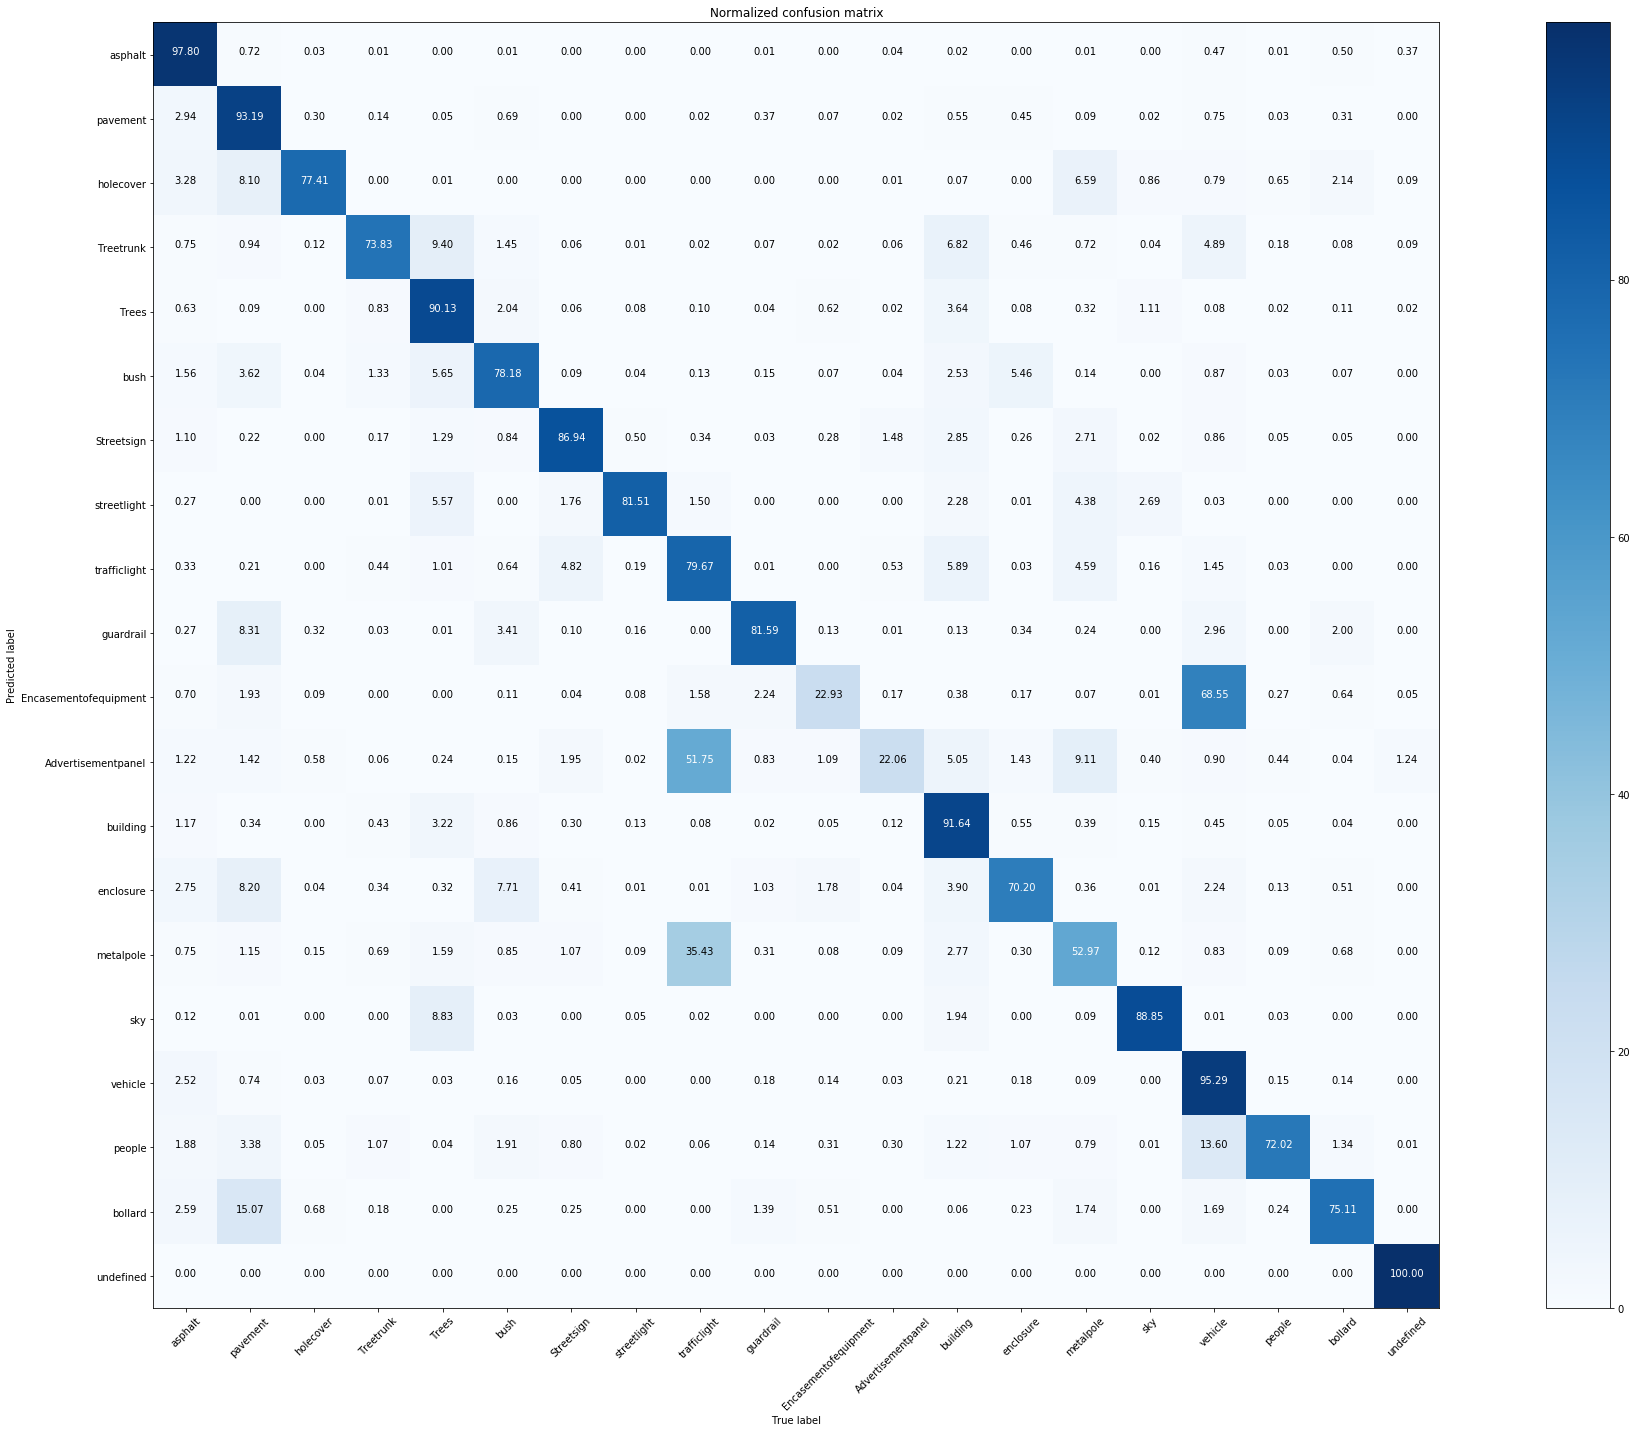

In [24]:
def _confusion_matrix(eval_segm, gt_segm):
    merged_maps = np.bitwise_or(np.left_shift(gt_segm.astype('uint16'), 8), eval_segm.astype('uint16'))
    hist = np.bincount(np.ravel(merged_maps))
    nonzero = np.nonzero(hist)[0]
    pred, label = np.bitwise_and(255, nonzero), np.right_shift(nonzero, 8)
    class_count = np.array([pred, label]).max() + 1
    conf_matrix = np.zeros([class_count, class_count], dtype='uint64')
    conf_matrix.put(pred * class_count + label, hist[nonzero])
    return conf_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm * 100.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.tight_layout()
    

confusion_matrix = np.empty([20,20],dtype=np.uint16)
s = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/resnet34/with_depth/testmasks_modified/*")
gt = glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/orig_masks_test/*")

gt_len = len(gt)
sc_len = len(s)
print gt_len
print sc_len

'''
for masks in s:
    if count == 100:        
        sc = []
        count = 1
    mk = cv2.imread(masks)     
    sc.append(mk)
    count = count + 1

for masks in gt:
    if count == 100:
        grt = []
        count = 1
    mk = cv2.imread(masks)
    grt.append(mk)
    count = count + 1

'''
for scores,masks in zip(s,gt):
    score = cv2.imread(scores)
    mask = cv2.imread(masks)    
    mt = _confusion_matrix(score,mask)
    if mt.shape<confusion_matrix.shape:
        mt.resize(confusion_matrix.shape)
    confusion_matrix = confusion_matrix + mt

#sc_arr = np.array(np.dstack(sc))
#grt_arr = np.array(np.dstack(grt))
#confusion_matrix = _confusion_matrix(sc_arr,grt_arr)
#print cnf_matrix.shape
# Plot non-normalized confusion matrix
#confusion_matrix = sum(cnf_matrix)
#confusion_matrix = np.asarray(confusion_matrix)
class_names = ['asphalt','pavement','holecover','Treetrunk','Trees','bush','Streetsign','streetlight','trafficlight',
               'guardrail','Encasementofequipment','Advertisementpanel','building','enclosure','metalpole','sky',
               'vehicle','people','bollard','undefined']
plt.figure(figsize=(30,20))
#plot_confusion_matrix(confusion_matrix, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure(figsize=(30,20))
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

# Find element wise mean and standard deviation in a list of lists

In [ ]:
cls_acc = []

x_dict = {0: 95.6611331568931, 1: 81.36090273368568, 2: 27.855528449539673, 3: 48.19998285042731, 4: 81.47870086761282, 5: 55.176142220980495, 6: 35.79003511111333, 7: 16.07771656348044, 8: 23.621260855965808, 9: 40.96724918696406, 10: 37.84076850778333, 11: 35.26690927349726, 12: 84.46012672775032, 13: 38.643091163078886, 14: 44.42174078140907, 15: 76.96140578642259, 16: 89.1362226994635, 17: 41.971777084246355, 18: 31.459812003425327}

y_dict = {0: 94.99838883121075, 1: 80.5688570596068, 2: 31.929757520305298, 3: 50.25111123378324, 4: 81.63895265991916, 5: 53.55037848701711, 6: 35.78686138050968, 7: 12.872410203247968, 8: 14.326333771200703, 9: 41.51927658079296, 10: 39.46191952209827, 11: 33.78383128567996, 12: 84.76489312731216, 13: 41.737547003249915, 14: 42.74645336969613, 15: 77.0637856470076, 16: 89.58452996274137, 17: 41.46280140885272, 18: 36.12464169335692}


#z = [94.7988252781112, 81.76397279414029, 27.063223733815825, 51.30567451526918, 80.62548431924422, 53.16905521202211,
#     33.64144613170761, 7.108270619246097, 15.653916085887044, 34.6642999627725, 35.31850600311085, 31.067265973381723,
#     84.9007290520551, 45.88887710672514, 46.893958413237506, 77.69188848491348, 89.09165512364372, 46.49300330607279,
#      34.07500489374315]

#cls_acc.append(x)
#cls_acc.append(y)
#cls_acc.append(z)
#cls_acc = np.mean([np.asarray(cls_acc[i]) for i in range(len(cls_acc))], axis=0)
#print cls_acc
#print np.mean(cls_acc)
x = x_dict.values()
y = y_dict.values()
arr = np.array([x, y])
print np.mean(arr,axis=0)
print np.std(arr,axis=0)
print np.mean(arr)

# Crop patches of 256 from images

In [ ]:
#img = cv2.imread("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/train/_cam1_1509443638578_000028.png",cv2.IMREAD_GRAYSCALE)    
img = cv2.imread("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/test/_cam1_1509443638578_000028.jpg")    
print (img.shape)
count=0
ht = img.shape[0]
wd = img.shape[1]
i=0
while i+256 <= ht:
    j=0
    while j+256 <= wd:
        print (i,j)
        crop_img = img[i:i+256, j:j+256] 
        cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/test/crop_%d.jpg" %(count), crop_img)
        #crop_img = crop_img.transpose((2,0,1))
        #crop_img = np.expand_dims(crop_img, axis=0)

        #crop_label = label[i:i+400, j:j+400]   
        #crop_label = crop_label[175:175+51, 175:175+51]
        #crop_label = cv2.cvtColor(crop_label,cv2.COLOR_RGB2GRAY)  
        #crop_label = np.expand_dims(crop_label, axis=0)
        #crop_label = np.expand_dims(crop_label, axis=0)

        #with h5py.File('/home/bharadwaj/CaffeUNet/dataset4/patches/%s_patch_%d.h5' %(name,count)) as hdf:
            #D1 = hdf.create_dataset('data', data = crop_img)            
            #D2 = hdf.create_dataset('label', data = crop_label) 
        j = j + 256
        count = count + 1
    i = i + 256

# Concatenate images to form a single image

In [ ]:
patches = sorted(glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/test/crop*"), key=stringSplitByNumbers)
count = 1
i = 0
j = 0

finImg = Image.new('RGB', (512, 512))
for imgs in sorted(patches, key=stringSplitByNumbers):     
    img = Image.open(imgs) 
    count2=count2+1
    if count<3:        
        finImg.paste(img,(i,j))
        i = i+256     
        count = count+1
    if count>2:
        j = j+256
        i = 0
        count = 1

finImg.save("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/test/new.jpg")  

In [ ]:
#dir = "." # current directory
#ext = ".jpg" # whatever extension you want

patches = sorted(glob.glob("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/test/crop*"), key=stringSplitByNumbers)
images = [cv2.imread(img) for img in patches]

patch_h = 256
patch_w = 256

height = sum(image.shape[0] for image in images)
width = sum(image.shape[1] for image in images)
output = np.zeros((512,512,3))
print output.shape

hzt = height/patch_h
ver = width/patch_w
count = 0
_h = 0
_w = 0
for image in images:
    h,w,d = image.shape
    #while _w < 512:
    output[_w:_w+w,_h:_h+h] = image
    _w = _w + 256
    #break
    _h = _h + 256
    
cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/Experiments/experiments_with_depth_Berlin/test/new.jpg", output)

In [ ]:
imgPatches = sorted(glob.glob("/home/bharadwaj/CaffeUNet/dataset4/segmentedResults_PNG/*"), key=stringSplitByNumbers)

horList1 =[]
horList2 =[]
horList3 =[]
horList4 =[]

pos = 0
i = 0

for pos, patches in enumerate(sorted(imgPatches, key=stringSplitByNumbers)):    
    
    while i < 24 and pos < 24:
        img = cv2.imread(imgPatches[pos])
        
        if i < 6:
            horList1.append(img)
            
        elif i > 5 and i <12:
            horList2.append(img)
            
        elif i > 11 and i < 18:
            horList3.append(img)
            
        else:
            horList4.append(img)
            
        pos = pos + 1
        i = i + 1
        
concImg1 = np.array(np.hstack(horList1), dtype=np.uint8)
concImg2 = np.array(np.hstack(horList2), dtype=np.uint8)
concImg3 = np.array(np.hstack(horList3), dtype=np.uint8)
concImg4 = np.array(np.hstack(horList4), dtype=np.uint8)

finImg1 = np.vstack((concImg1, concImg2))
finImg1 = np.vstack((finImg1, concImg3))
finImg = np.vstack((finImg1, concImg4))

cv2.imwrite("/home/bharadwaj/CaffeUNet/dataset4/segmentedResults_PNG/final.jpg", finImg)

In [ ]:
img1 = Image.open("/home/bharadwaj/CaffeUNet/dataset4/data/tmp/_cam1_1509443561072_000016_patch_1.jpg") 
img2 = Image.open("/home/bharadwaj/CaffeUNet/dataset4/data/tmp/_cam1_1509443561072_000016_patch_8.jpg") 
finImg = Image.new('RGB', (1920, 1440))
finImg.paste(img1,(0,0))
finImg.paste(img2,(0,240))
finImg.save("/home/bharadwaj/CaffeUNet/dataset4/data/tmp/new.jpg")

In [56]:
f = glob.glob("/home/bharadwaj/Desktop/dpdb_1/1/*")
for im in f:
    f_n = im.split("/")[6].split(".")[0]
    cmd = "cp /home/bharadwaj/CaffeUNet/dataset4/Experiments/test_304X304/%s.jpg /home/bharadwaj/Desktop/dpdb_models/newimage" %(f_n)
    os.system(cmd) 